# Planet : Amazon space

In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import torchvision.transforms.functional as F

In [2]:
data_folder = '../IPEO_Planet_project'
if not os.path.exists(data_folder):
    data_folder = input("Enter the data folder path: ")
    assert os.path.exists(data_folder), "I did not find the folder at, "+str(data_folder)

# Loading the dataset

In [3]:
labels_dt = pd.read_csv(f'{data_folder}/train_labels.csv',dtype=str)
print(labels_dt.head())

  image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road


In [4]:
label_test =  labels_dt.iloc[0,1]
print(label_test)
print(type(label_test))

haze primary
<class 'str'>


In [5]:
print(label_test.split())

['haze', 'primary']


In [6]:
img_name_test = os.path.join(f'{data_folder}/train-jpg', labels_dt.iloc[5, 0])
img_name_test = f'{img_name_test}.jpg'
print(img_name_test)

../IPEO_Planet_project/train-jpg\train_5.jpg


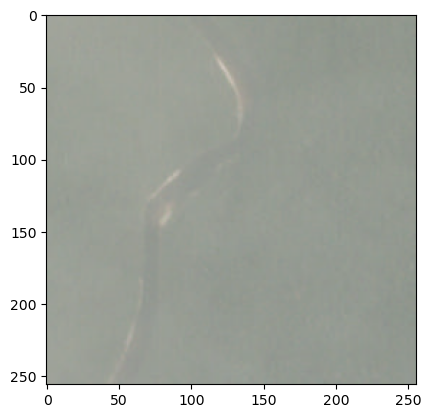

In [7]:
plt.figure()
image = io.imread(img_name_test)
plt.imshow(image)

## Custom made Class for dataset

See this tutorial for help:
<https://pytorch.org/tutorials/beginner/data_loading_tutorial.html>

In [8]:
class AmazonSpaces(Dataset):
    """Amazon aerial image dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.labels.iloc[idx, 0])
        img_name = f'{img_name}.jpg'

        image = io.imread(img_name)
        labels = self.labels.iloc[idx, 1]
        labels = labels.split()

        '''
        #old class output
        sample = {'image': image, 'labels': labels}
        '''

        if self.transform:
            image = self.transform(image)
        return image, labels

In [9]:
Amazon_dataset = AmazonSpaces(csv_file=f'{data_folder}/train_labels.csv',
                                    root_dir=f'{data_folder}/train-jpg')

## Having some fun with transforms
Just testing some transforms and how to implement into dataset
First creating and Adjust_Saturation class to be able to apply adjust_saturation the same way as the other transforms class

In [10]:
class AdjustSaturation(object):
    """Adjust the saturation of a tensor image.
    Args:
        saturation factor (float): if 0 -> black and white, if 1 -> same as the input
    """

    def __init__(self, saturation_factor):
        assert isinstance(saturation_factor, (int,float))
        self.saturation_factor = saturation_factor

    def __call__(self, img):
        new_tensor = transforms.functional.adjust_saturation(img, self.saturation_factor)

        return new_tensor

In [11]:
Test_transforms = transforms.Compose([transforms.ToTensor(),transforms.CenterCrop(256),transforms.RandomAutocontrast(p=1), AdjustSaturation(2)])

In [12]:
transformed_dataset = AmazonSpaces(csv_file=f'{data_folder}/train_labels.csv',
                                    root_dir=f'{data_folder}/train-jpg', transform=Test_transforms)

## Visualizing the two datasets:
1) The dataset without transforms

0 (256, 256, 3) 2
1 (256, 256, 3) 4
2 (256, 256, 3) 2
3 (256, 256, 3) 2


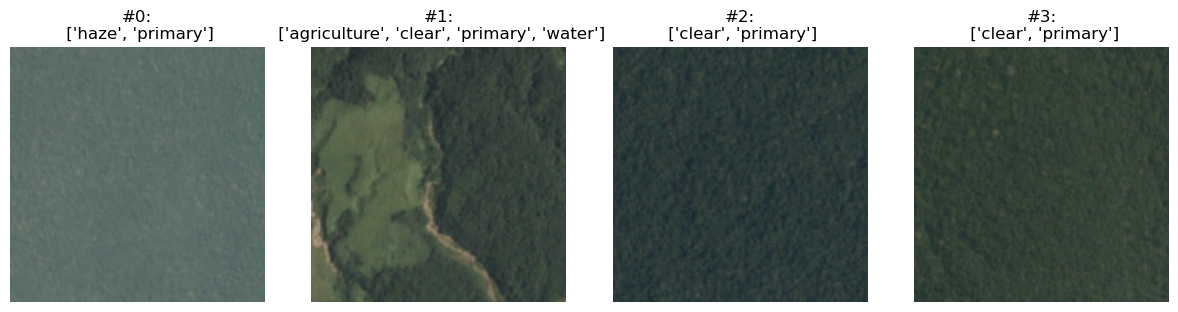

In [13]:
plt.figure(figsize=(12,10))

for i in range(len(Amazon_dataset)):
    #sample = Amazon_dataset[i]
    #print(i, sample['image'].shape, sample['labels']) #old class output
    #labels = sample['labels']
    #image = sample['image']
    image,labels = Amazon_dataset[i]
    print(i, image.shape, len(labels))
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title(f'#{i}:\n {labels}')
    ax.axis('off')
    img = F.to_pil_image(image)
    ax.imshow(img)
    if i == 3:
        plt.show()
        break

2) Then the one with tranforms

0 torch.Size([3, 256, 256]) 2
1 torch.Size([3, 256, 256]) 4
2 torch.Size([3, 256, 256]) 2
3 torch.Size([3, 256, 256]) 2


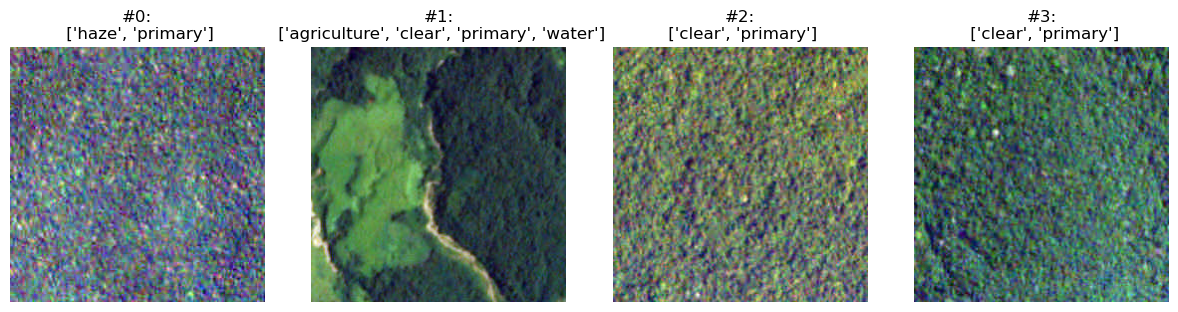

In [14]:
plt.figure(figsize=(12,10))

for i in range(len(transformed_dataset)):
    ## old class output:
    #sample = transformed_dataset[i]
    #print(i, sample['image'].shape, sample['labels'])
    #labels = sample['labels']
    #image = sample['image']

    image,labels = transformed_dataset[i] #new clas output

    print(i, image.shape, len(labels))
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title(f'#{i}:\n {labels}')
    ax.axis('off')
    img = F.to_pil_image(image)
    ax.imshow(img)
    if i == 3:
        plt.show()
        break

# Into Dataloader

In [15]:
train_loader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=0)

## Testing with plotting

In [16]:
# Helper function to show a batch
def show_image_batch(sample_batched):
    #images_batch, labels = sample_batched['image'], sample_batched['labels'] #old class output
    images_batch, labels = sample_batched
    batch_size = len(images_batch)
    fig, axs = plt.subplots(1, batch_size)
    for i in range(batch_size):
        img = F.to_pil_image(images_batch[i])
        axs[i].imshow(img)
        axs[i].set_title(f'#{i}:\n {labels[i]}')
    fig.set_figheight(10)
    fig.set_figwidth(12)
    plt.tight_layout()
    plt.show()

In [17]:
iterator = iter(train_loader)

for i_batch in range(10):
    sample_batched = next(iterator)
    # observe 4th batch and stop.
    if i_batch == 3:
        show_image_batch(sample_batched)
        break

RuntimeError: each element in list of batch should be of equal size